#### Data processing notebook

This notebook will process the data acquired on experiments around the latency to fetch a file from an S3 bucket directly or passing through AWS CDN, a.k.a CloudFront.

#### Methodology

An S3 bucket is deployed in each continent 

["sa-east-1", "us-east-1", "af-south-1", "ap-northeast-1", "eu-west-1", "ap-southeast-2"](https://github.com/gpspelle/cdk-s3-cdn-experiment/blob/main/cdk/bin/pfg.ts#L53)

São Paulo (Brazil), North Virginia (United States), South Africa, Tokyo (Japan), Ireland, Sydney (Australia).

On top of that, CloudFront is deployed and is serving the content from each ofthese buckets from a specific route. So, if https://gpspelle.click is the domain used by CloudFront, https://gpspelle.click/sa-east-1/* requests are redirected to the São Paulo (sa-east-1) bucket.

To measure the difference of performance with or without cloudfront, for each region, the files from the bucket are fetched passing through cloudfront and not passing through it. There's a log containing the result of these requests for each region.

Each file consists of a fixed amount of lines, in our early experiments, it's 10, where each line contains the following information:


- ProcessDate := when the fetch request was executed
- SourceUrl := URL used to get the content, it can be a CF url or an S3 url
- FileSize := size of the file that is fetched
- ElapsedTime := time to fetch the file
- StatusCode := status code of the request

For now, we are considering files with [1kb, 10kb, 100kb, 1000kb](https://github.com/gpspelle/cdk-s3-cdn-experiment/blob/main/utils/fetchFiles.cjs#L112)


If you are running on a mac m1: brew install gdal proj

In [1]:
!pip install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from os import listdir
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
AWS_regions = {
    'sa-east-1': 'Brazil',
    'us-east-1': 'United States of America',
    'af-south-1': 'South Africa',
    'ap-northeast-1': 'Japan',
    'eu-west-1': 'Ireland',
    'ap-southeast-2': 'Australia'
}

file_sizes = ["1kb", "10kb", "100kb", "1000kb"]
custom_domain = "https://gpspelle.click"

In [4]:
# Helper function to get the .csv files generated by the fetch command
def find_csv_filenames(path_to_dir, suffix=".csv"):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [5]:
filenames = find_csv_filenames(".")

In [6]:
logs = {}
for filename in filenames:
    df = pd.read_csv(filename)
    assert (df['StatusCode'] == 200).all()
    for AWS_region in AWS_regions:
        if AWS_region in filename:
            df.drop(columns=['StatusCode'], inplace=True)
            logs_per_file_size_and_source = {}
            for file_size in file_sizes:
                df_file_size = df[df['FileSize'] == file_size]
                df_file_size_and_source = df_file_size.groupby('SourceUrl')
                logs_per_file_size_and_source[file_size] = df_file_size_and_source
            logs[AWS_region] = logs_per_file_size_and_source

In [22]:
!pip install pip install dataframe-image

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.3/552.3 kB 8.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 5.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [27]:
import matplotlib.pyplot as plt
from pandas.plotting import table
import dataframe_image as dfi

for AWS_region in AWS_regions:
    for file_size in file_sizes:
        desc = logs[AWS_region][file_size].describe()
        dfi.export(desc, 'df-' + AWS_region + '-' + file_size + '.png')

[0628/190805.043133:INFO:headless_shell.cc(660)] Written to file /var/folders/st/y0fjdkf52zgd0xg60bljqr0h0000gn/T/tmp5ynie4ib/temp.png.
[0628/190805.802891:INFO:headless_shell.cc(660)] Written to file /var/folders/st/y0fjdkf52zgd0xg60bljqr0h0000gn/T/tmp8jl6ifcw/temp.png.
[0628/190806.552661:INFO:headless_shell.cc(660)] Written to file /var/folders/st/y0fjdkf52zgd0xg60bljqr0h0000gn/T/tmp8zejhyk5/temp.png.
[0628/190807.301626:INFO:headless_shell.cc(660)] Written to file /var/folders/st/y0fjdkf52zgd0xg60bljqr0h0000gn/T/tmpzzcw6x_t/temp.png.
[0628/190808.050608:INFO:headless_shell.cc(660)] Written to file /var/folders/st/y0fjdkf52zgd0xg60bljqr0h0000gn/T/tmpfgoqq8xs/temp.png.
[0628/190808.801731:INFO:headless_shell.cc(660)] Written to file /var/folders/st/y0fjdkf52zgd0xg60bljqr0h0000gn/T/tmpmqmtf8ge/temp.png.
[0628/190809.552292:INFO:headless_shell.cc(660)] Written to file /var/folders/st/y0fjdkf52zgd0xg60bljqr0h0000gn/T/tmpwvimd2yz/temp.png.
[0628/190810.319563:INFO:headless_shell.cc(660)]

ElapsedTime              \
                                                         count        mean   
SourceUrl                                                                    
https://gpspelle.click/sa-east-1/10kb                     10.0  336.925267   
https://sa-east-1-latency-test-pfg-unicamp.s3.s...        10.0  186.765679   

                                                                           \
                                                           std        min   
SourceUrl                                                                   
https://gpspelle.click/sa-east-1/10kb               837.373510  34.884250   
https://sa-east-1-latency-test-pfg-unicamp.s3.s...   95.559381  97.332541   

                                                                            \
                                                           25%         50%   
SourceUrl                                                                    
https://gpspelle.click/sa-east-1/10kb                44.849708   57.503813   
https://sa-east-1-latency-test-pfg-unicamp.s3.s...  127.961885  146.796833   

                                                                             
                                                           75%          max  
SourceUrl                                                                    
https://gpspelle.click/sa-east-1/10kb                70.401614  2714.615708  
https://sa-east-1-latency-test-pfg-unicamp.s3.s...  238.229447   388.882416

In [7]:
fetch_latency_average = {}
for AWS_region in AWS_regions:
    fetch_latency_average[AWS_region] = {}
    for file_size in file_sizes:
        df = logs[AWS_region][file_size]
        fetch_latency_average[AWS_region][file_size] = df['ElapsedTime'].mean().to_dict()

In [ ]:
fetch_latency_average_ = {}
for AWS_region in AWS_regions:
    fetch_latency_average_[AWS_region] = {}
    for file_size in file_sizes:
        df = logs[AWS_region][file_size]
        fetch_latency_average_[file_size][AWS_region] = df['ElapsedTime'].mean().to_dict()

In [8]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [9]:
print(pretty(fetch_latency_average))

sa-east-1
	1kb
		https://gpspelle.click/sa-east-1/1kb
			733.8958291053772
		https://sa-east-1-latency-test-pfg-unicamp.s3.sa-east-1.amazonaws.com/sa-east-1/1kb
			144.75353779792786
	10kb
		https://gpspelle.click/sa-east-1/10kb
			336.92526683807375
		https://sa-east-1-latency-test-pfg-unicamp.s3.sa-east-1.amazonaws.com/sa-east-1/10kb
			186.76567883491515
	100kb
		https://gpspelle.click/sa-east-1/100kb
			231.2195915699005
		https://sa-east-1-latency-test-pfg-unicamp.s3.sa-east-1.amazonaws.com/sa-east-1/100kb
			339.31523766517637
	1000kb
		https://gpspelle.click/sa-east-1/1000kb
			208.14604573249818
		https://sa-east-1-latency-test-pfg-unicamp.s3.sa-east-1.amazonaws.com/sa-east-1/1000kb
			1188.8530958652495
us-east-1
	1kb
		https://gpspelle.click/us-east-1/1kb
			58.4272581577301
		https://us-east-1-latency-test-pfg-unicamp.s3.us-east-1.amazonaws.com/us-east-1/1kb
			849.2787250518799
	10kb
		https://gpspelle.click/us-east-1/10kb
			76.48697919845581
		https://us-east-1-latency-te

In [10]:
world_base = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_base = world_base[(world_base.pop_est>0) & (world_base.name!="Antarctica")]
world_base['fetch_latency'] = np.nan

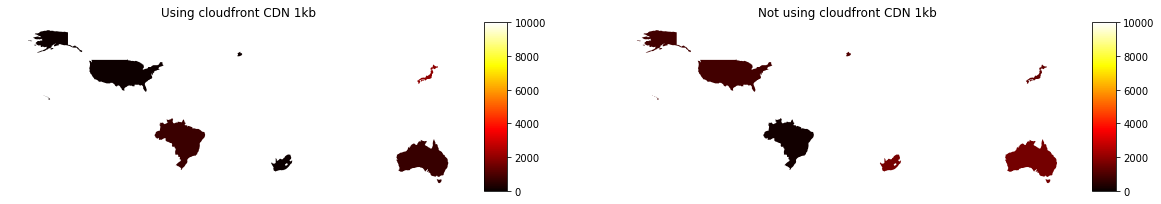

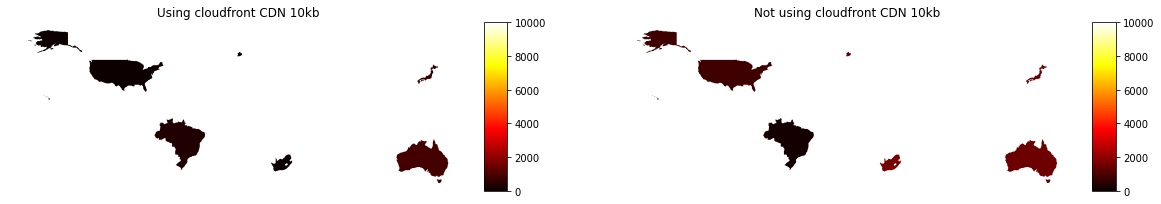

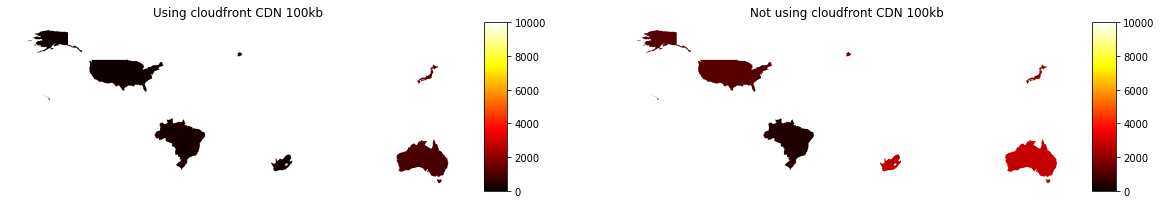

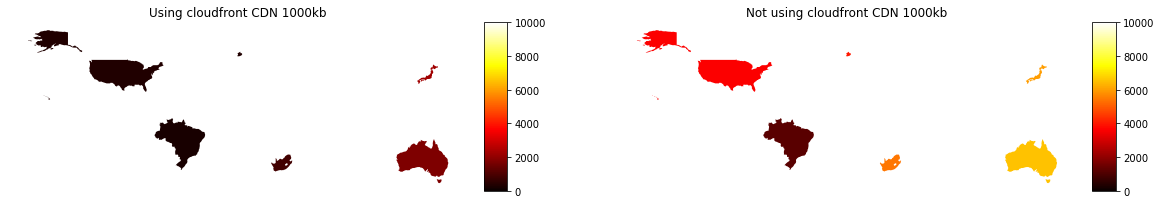

In [11]:
worlds = {}
for i, file_size in enumerate(file_sizes):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20,20))
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    title1="Using cloudfront CDN " + file_size
    ax1.set_title(title1)
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    title2="Not using cloudfront CDN " + file_size
    ax2.set_title(title2)
    ax1.axis('off')
    ax2.axis('off')
    worlds[file_size] = {}
    worlds[file_size]['custom_domain'] = world_base.copy(deep=True)
    worlds[file_size]['not_custom_domain'] = world_base.copy(deep=True)
    for AWS_region in AWS_regions:
        for fetch_source_url in fetch_latency_average[AWS_region][file_size]:
            if custom_domain in fetch_source_url:
                # using custom domain and cloud front CDN
                region = AWS_regions[AWS_region]
                world = worlds[file_size]['custom_domain'] 
                world.loc[world.name == region, 'fetch_latency'] = fetch_latency_average[AWS_region][file_size][fetch_source_url]
            else:
                # not custom domain directly S3 bucket
                region = AWS_regions[AWS_region]
                world = worlds[file_size]['not_custom_domain'] 
                world.loc[world.name == region, 'fetch_latency'] = fetch_latency_average[AWS_region][file_size][fetch_source_url]
                title="Not using cloudfront cdn " + file_size
        
    worlds[file_size]['custom_domain'].plot(ax=ax1, cax=cax1, column='fetch_latency', cmap="hot", legend=True, vmax=10000, vmin=0)
    worlds[file_size]['not_custom_domain'].plot(ax=ax2, cax=cax2, column='fetch_latency', cmap="hot", legend=True, vmax=10000, vmin=0)
    plt.savefig(file_size + '.jpg', bbox_inches='tight')